In [270]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention,BatchNormalization,Multiply,
    Softmax, Reshape,Conv2DTranspose, Conv2D, Concatenate, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,Activation
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import TruncatedNormal
from einops import rearrange
from tensorflow.keras import backend as K

In [3]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [4]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [5]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [6]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


In [8]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")
print(y_train.shape, y_test.shape)
# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128) (569, 128, 128)
(2272, 128, 128, 1) (569, 128, 128, 1)


In [226]:
def plot_images(X_test, y_test, model_mask, selected_indices):
    for i in selected_indices:
        plt.figure(figsize=(15,5))

        # orignal image
        plt.subplot(1,4,1)
        plt.imshow(X_test[i].squeeze())
        plt.title("Orignal Image")
        plt.axis("off")

        # Orignal Mask
        plt.subplot(1,4,2)
        plt.imshow(y_test[i].squeeze(), cmap='gray') # viridis
        plt.title('Orignal Mask')
        plt.axis("off")

        # Model Mask
        plt.subplot(1,4,3)
        plt.imshow(model_mask[i].squeeze(), cmap='gray')
        plt.title('Model Mask')
        plt.axis("off")
    plt.show()

In [227]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt

In [272]:
def calculate_IOU(y_true, y_pred, threshold = 0.5):
    y_pred = (y_pred > threshold).astype(np.uint8) # Binarize predictions
    intersection = np.sum(y_true * y_pred, axis = (1,2)) # Per image
    union = np.sum(y_true + y_pred, axis = (1,2)) - intersection # Per image
    iou = np.mean(intersection / (union + 1e-6)) # Avoid division by zero
    return iou

def Training_IoU(model, X_train, y_train):
    train_predictions = model.predict(X_train)
    train_predictions = train_predictions.squeeze()  # Shape:(height, width)
    y_train = y_train.squeeze()  # Shape:, height, width)

    train_iou = calculate_IOU(y_train, train_predictions)
    return train_iou

def Testing_IoU (model, X_test, y_test):
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.squeeze()  # Shape: ( height, width)
    y_test = y_test.squeeze()  # Shape: (batch_size, height, width)

    test_iou = calculate_IOU(y_test, test_predictions)
    return test_iou
    
    

In [273]:
def trained_history(path, trained_model, algo, X_train, y_train, X_test, y_test):
  with open(path,'rb') as file:
    loaded_history = pickle.load(file)
  train_accuracy = loaded_history['accuracy']
  train_loss = loaded_history['loss']

  val_accuracy = loaded_history['val_accuracy']
  val_loss = loaded_history['val_loss']

  data = {
    'Algorithm': [algo[0], algo[1]],
    'Accuracy': [train_accuracy[-1], val_accuracy[-1]],
    'Loss': [train_loss[-1], val_loss[-1]],
    'mIOU': [Training_IoU(trained_model,X_train, y_train), Testing_IoU(trained_model,X_test, y_test)]
  }

  df = pd.DataFrame(data)

  return df

# **Transformer layers**

### Patch Partition Layer

The first component of the Swin-T architecture is a Path Parition layer which is used to partition an input image into multiple small patches.

In TensorFlow, we can simply use the [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) function to extract patches. We can use it inside a custom Layer to make it easy to use later when building the model

In [152]:
@keras.saving.register_keras_serializable()
class PatchPartition(Layer):
    def __init__(self, window_size, channles=3):
        super(PatchPartition, self).__init__()
        self.window_size = window_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
        

In [18]:
batch = X_train
window = 4
patches = PatchPartition(window)(batch)
patches.shape

TensorShape([2272, 1024, 48])

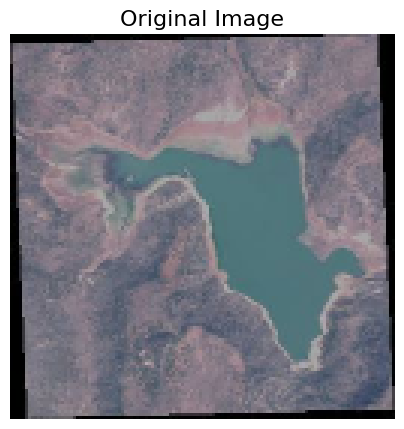

In [19]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].astype("uint8"))
plt.title("Original Image", fontsize=16)
plt.axis("off")
plt.show()

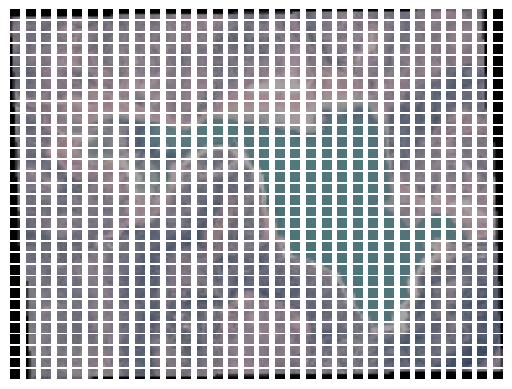

In [20]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (window, window, 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

### Linear Embedding layer
The second component in the Swin-T architecture is the Linear Embedding layer which is simply a combination of projection and embedding layers. It is used to calculate the patch embedding and the position embedding then add both as illustrated with the following diagram

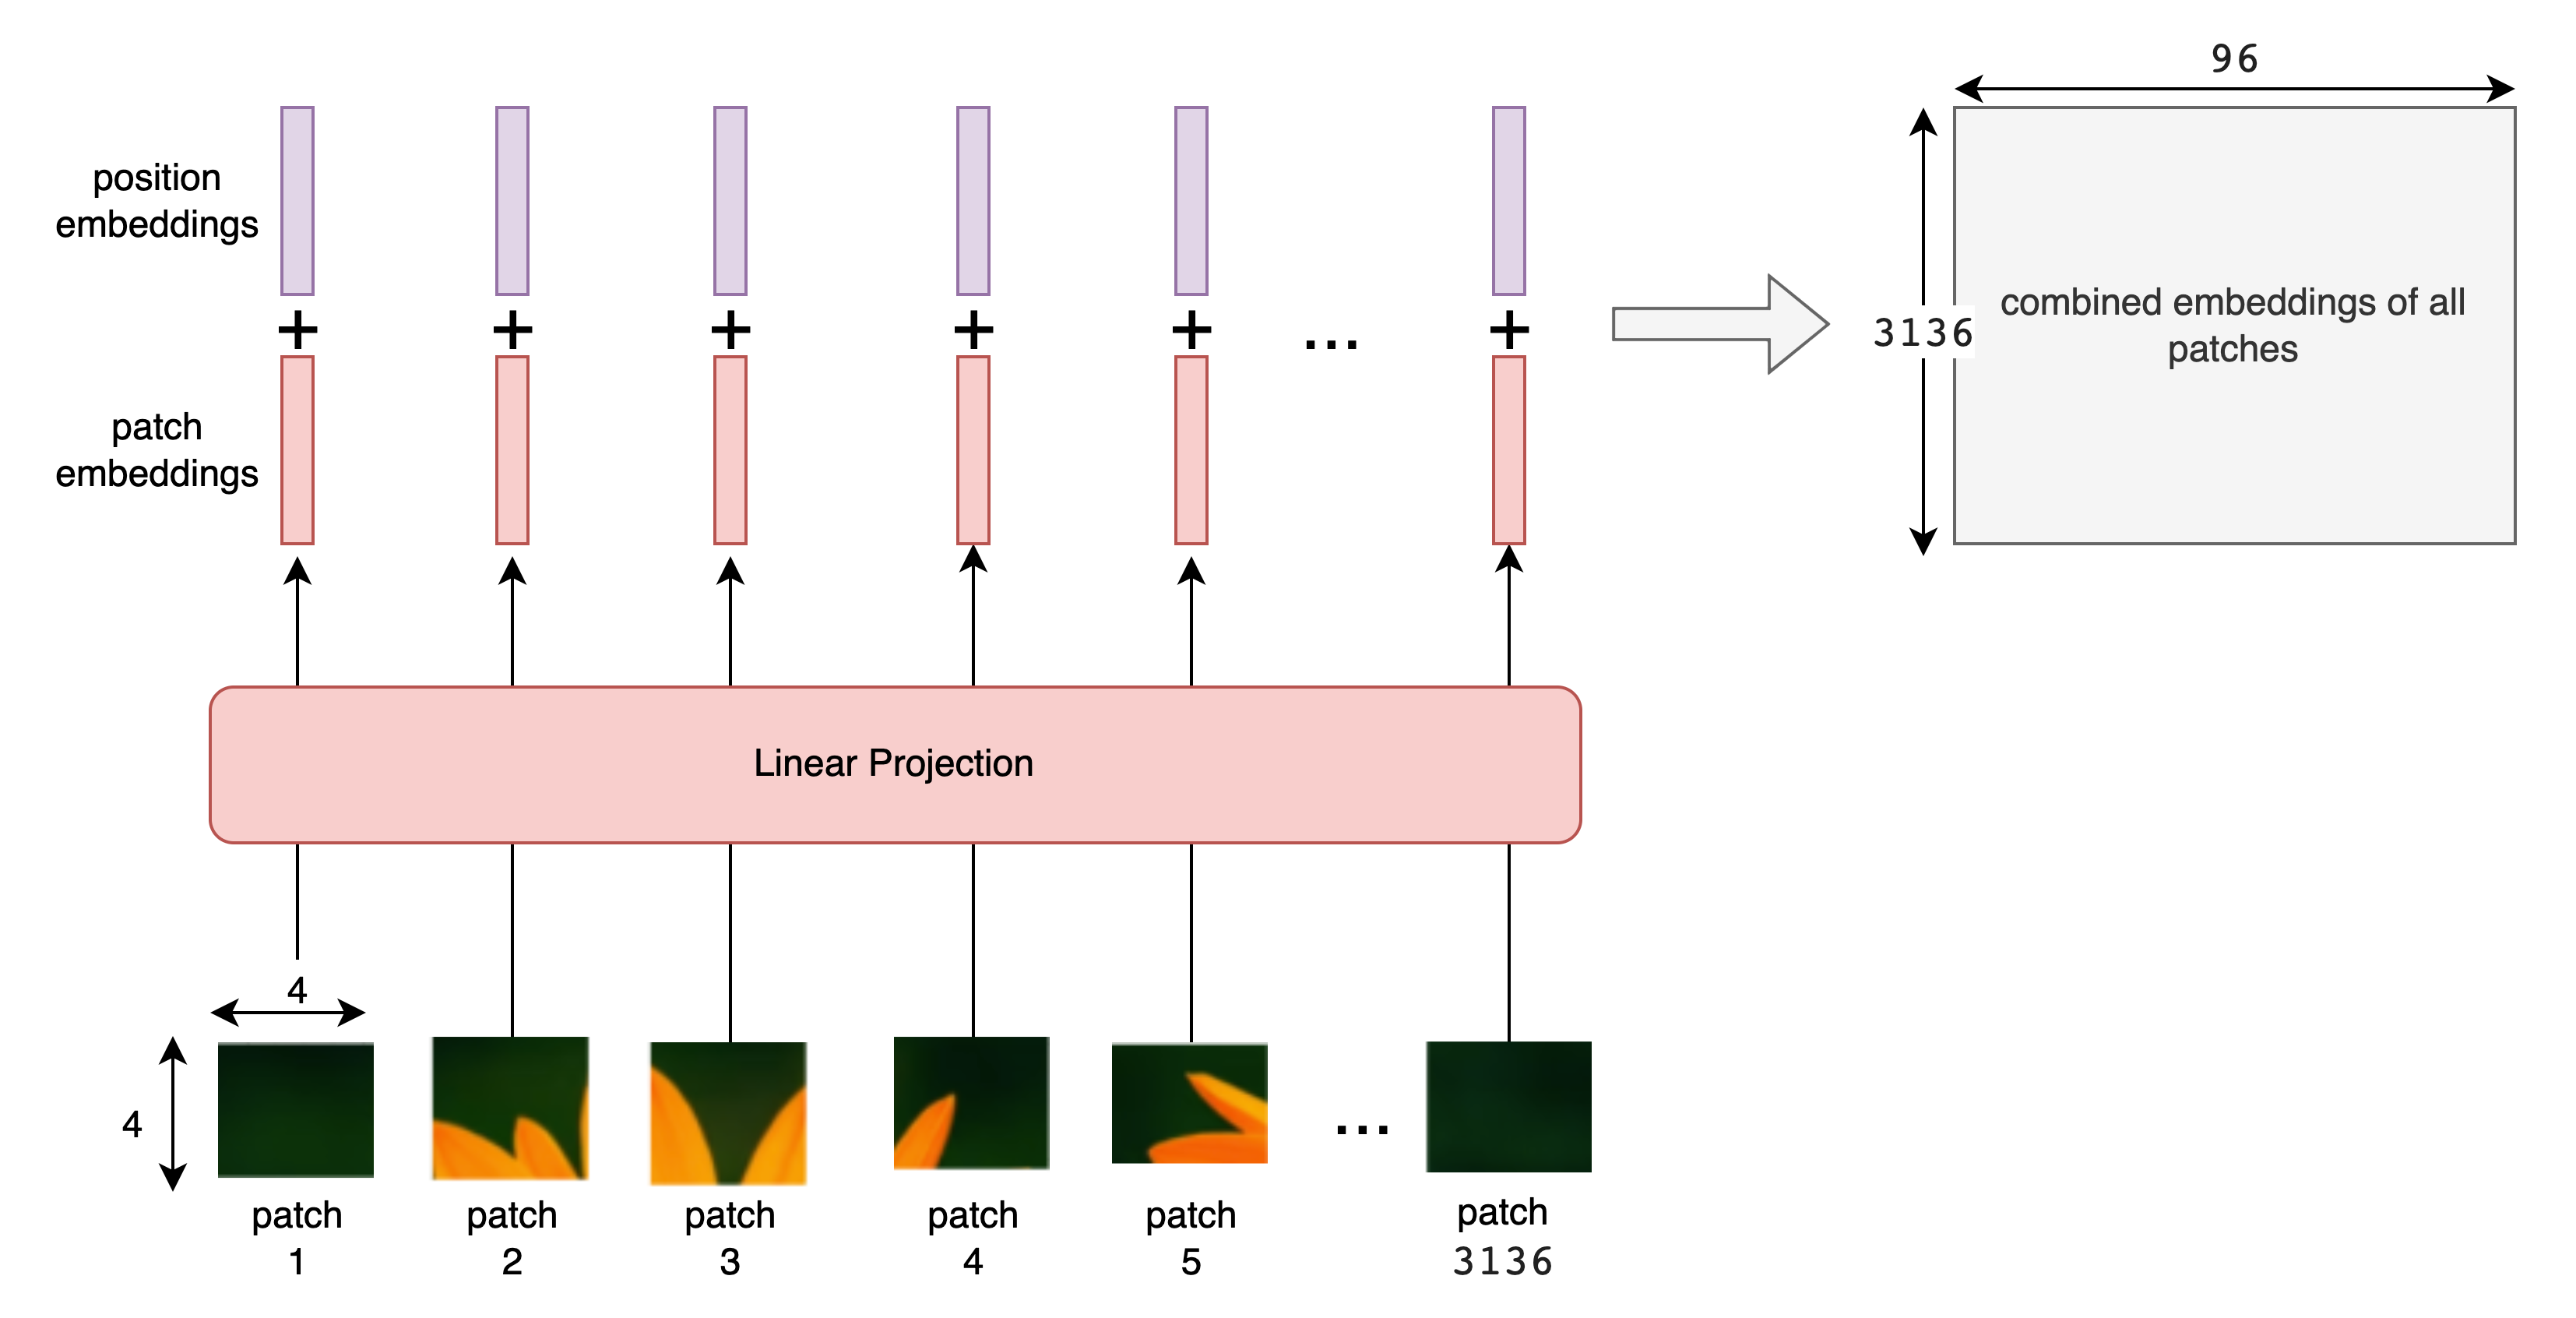

In [153]:
@keras.saving.register_keras_serializable()
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

We can confirm that the output of this layer is as expected `2272, 1024, 96`. Here 96 is `projection dimension`

`num_patches = image_height/window_size * image_width/window_size = 128/4 * 128/4 = 1024`

In [23]:
data = (patches.shape[1], patches.shape[2])
print(data)
embeddings = LinearEmbedding(1024, 12)(patches)
embeddings.shape

(1024, 48)


TensorShape([2272, 1024, 12])

### Patch Merging layer
Patch merging as it may indicate is used to merge smaller patches into larger ones. Let's look at the illustration to understand what this layer is doing, if the input of the layer is an `8 x 8` pixel image with 4 patches of `4 x 4` then the output becomes an `8 x 8` pixels but with one large patch of `8 x 8` plus an additional channel layer as channel layers are doubled.

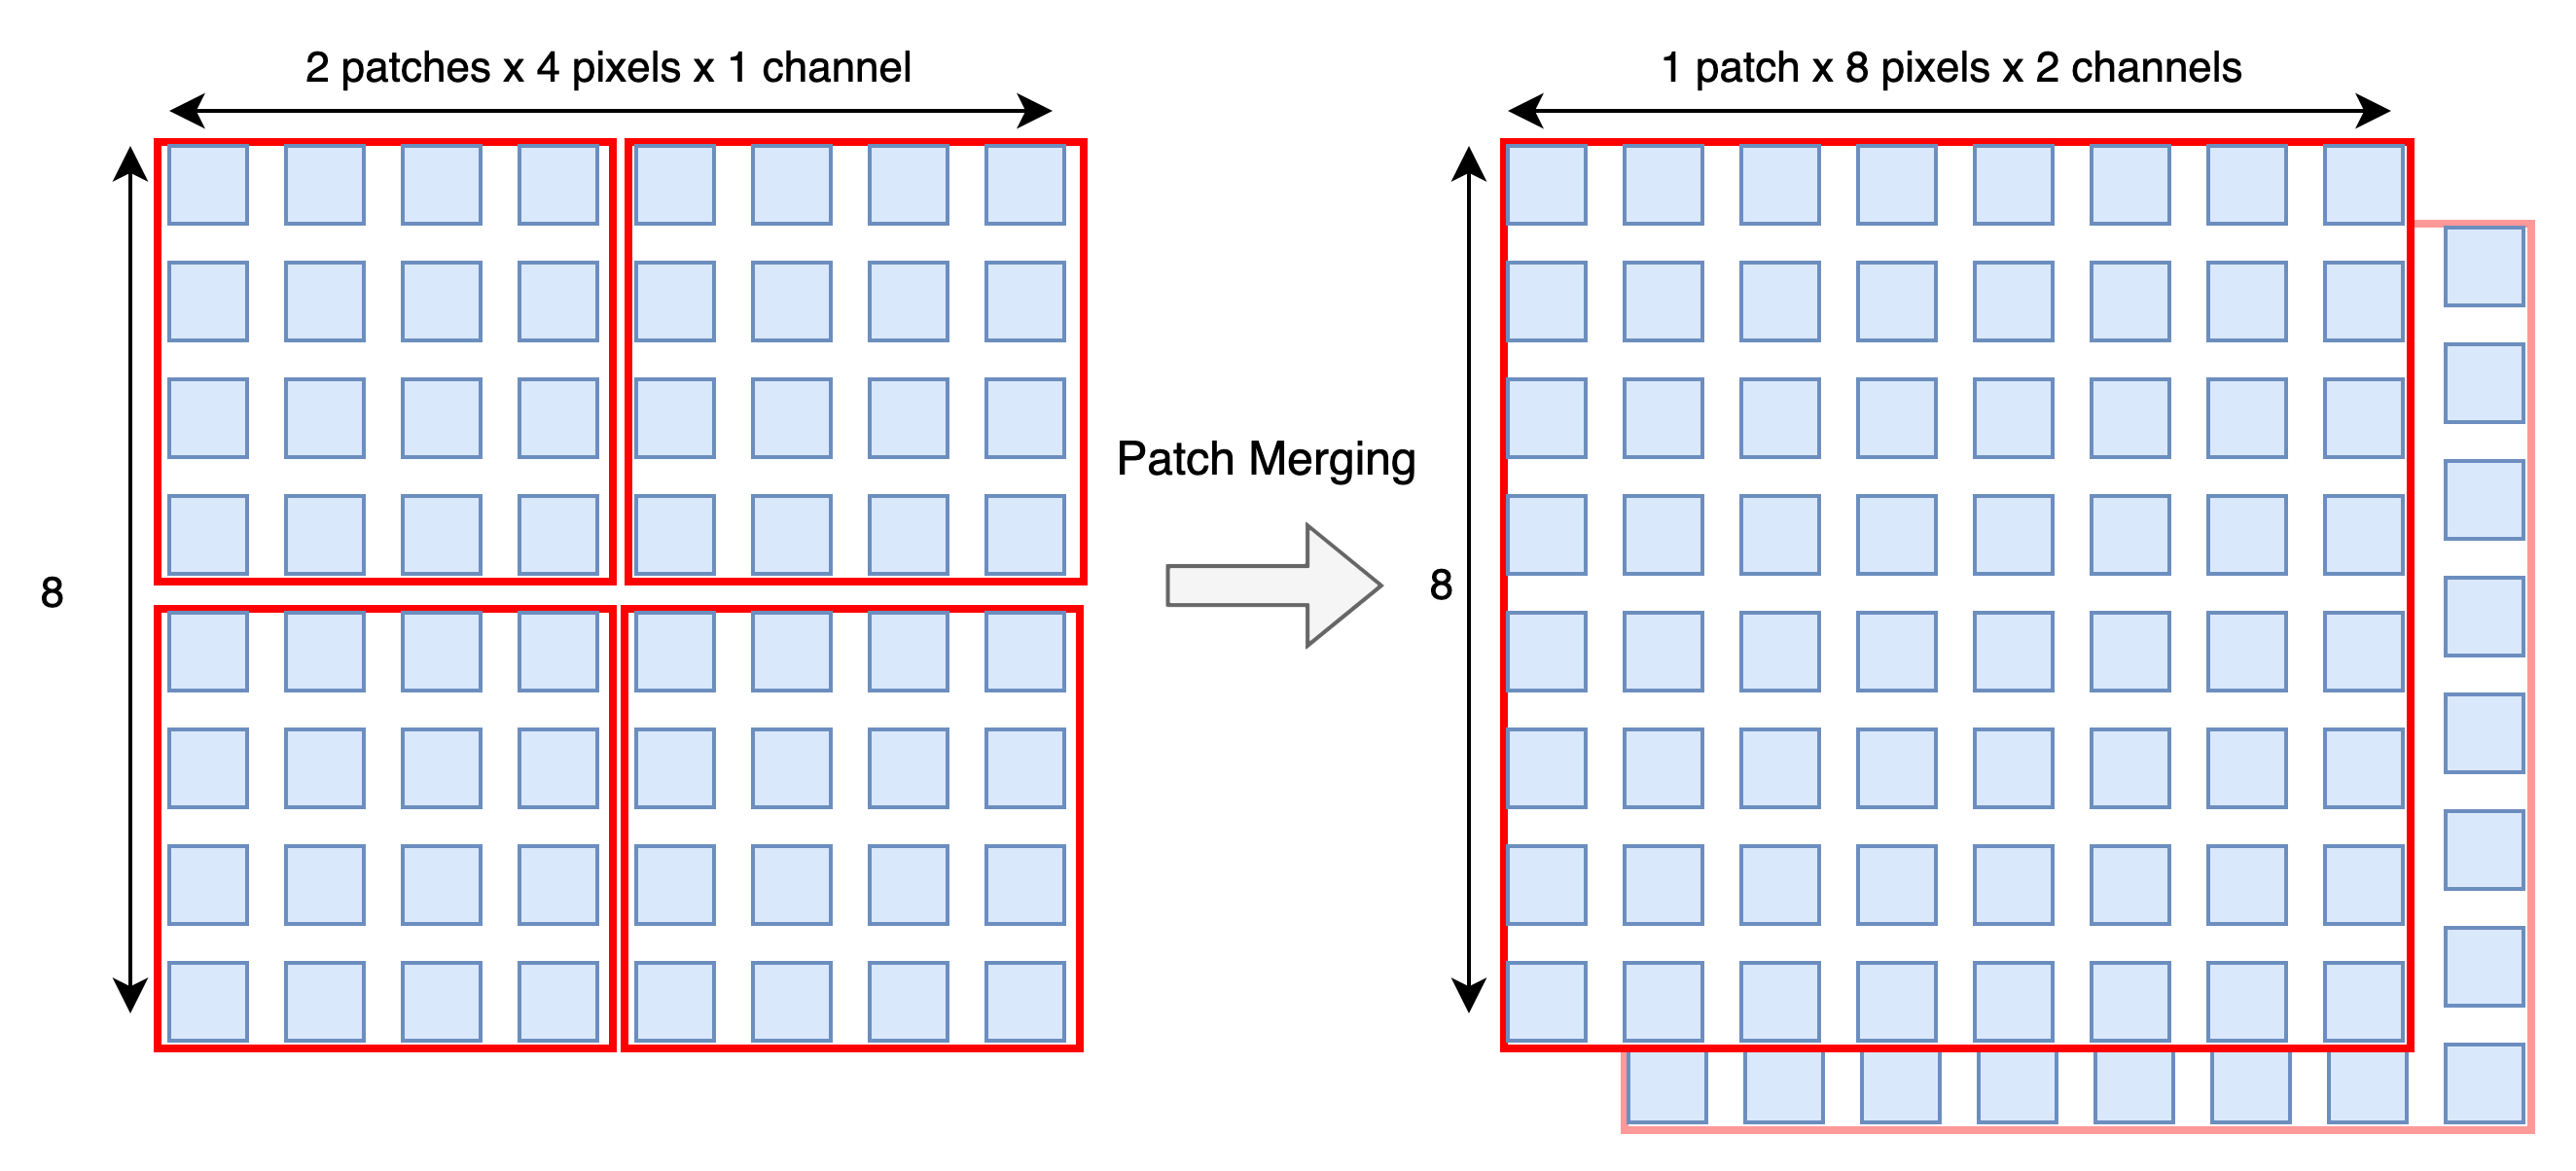

This layer can be simply implemented as a linear layer so that we can easily define the size of the output and double the channels as follows

In [154]:
@keras.saving.register_keras_serializable()
class PatchMerging(Layer):
    def __init__(self, input_resolution, channels):
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution
        self.channels = channels
        self.linear_trans = Dense(2 * channels, use_bias=False)

    def call(self, x):
        height, width = self.input_resolution
        _, _, C = x.get_shape().as_list()

        # Reshape into 2D grid
        x = tf.reshape(x, shape=(-1, height, width, C))

        # Split into 4 patches
        x0 = x[:, 0::2, 0::2, :] # Top-left
        x1 = x[:, 1::2, 0::2, :] # Bottom-left
        x2 = x[:, 0::2, 1::2, :] # Top-right
        x3 = x[:, 1::2, 1::2, :] # Bottom-right

        # Concatenate along the channel dimension
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        
        # Reshape to a flattened grid and apply linear transformation
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        
        return self.linear_trans(x) 

In [25]:
channels = 48
num_patch_x = 128 // 2
num_patch_y = 128 // 2
out_patches = PatchMerging((num_patch_x, num_patch_y), channels)(patches)
print(f'Input shape (B,   H * W,  C) = {patches.shape}')
print(f'Ouput shape (B, H/2*W/2, 4C) = {out_patches.shape}')

Input shape (B,   H * W,  C) = (2272, 1024, 48)
Ouput shape (B, H/2*W/2, 4C) = (568, 1024, 96)


### Patch Expanding Layer

Patch Expanding Layer is the reverse operation of patch merging. It is used to expand larger patches into smaller ones. This layer increases the spatial resolution of the input image while reducing the number of channels.

If the input of the patch expanding layer is an image of size `8 x 8` pixels with `4` patches of size `8 x 8` (i.e., a larger patch), the output would be an `8 x 8` image, but with multiple smaller patches (e.g., `4 x 4` patches). Additionally, the number of channels would be reduced.

In [155]:
@keras.saving.register_keras_serializable()
class PatchUnmerging(tf.keras.layers.Layer):

    def __init__(self, target_resolution, channels, scale, return_vector=True):
        super().__init__()
        
        self.target_resolution = target_resolution
        self.channels = channels
        self.scale = scale
        self.return_vector = return_vector
        
        # Linear transformations that doubles the channels 
        self.linear_trans1 = Conv2D(scale*channels, kernel_size=1, use_bias=False)

        
    def call(self, x):
        H, W = self.target_resolution
        B, L, C = x.get_shape().as_list()
        
        assert (L == H * W), 'input feature has wrong size'

        x = tf.reshape(x, (-1, H, W, C))
        
        x = self.linear_trans1(x)
        
        # rearange depth to number of patches
        x = tf.nn.depth_to_space(x, self.scale, data_format='NHWC')
        
        if self.return_vector:
            # Convert aligned patches to a patch sequence
            x = tf.reshape(x, (-1, L*self.scale*self.scale, C//2))

        return x

In [ ]:
num_patch = (int(np.sqrt(out_patches.shape[1])), int(np.sqrt(out_patches.shape[1])))  # Number of patches in height and width
embed_dim = out_patches.shape[2]        # Embedding dimension
upsample_rate = 2     # Upsampling rate
return_vector = True 

patch_unmerging_layer = PatchUnmerging(num_patch, embed_dim, upsample_rate, return_vector=return_vector)
# Pass the sample input through the layer
output = patch_unmerging_layer(out_patches)

# Print the shapes of input and output
print("Input shape:", out_patches.shape)  # Should be (8, 256, 96)
print("Output shape:", output.shape)

# **Swin Layers**

### Swin Transfomer block
The Swin Transformer block combines two Transofmer Encoder blocks but uses a window based self-attentions as illustrated in the following diagram. In this section, we will examine each component of this bloc and implement it in TensorFlow

> Note: W-MSA stands for Window Multi-head Self-Attention and SW-MSA stands for Shifted Window Multi-head Self-Attention.

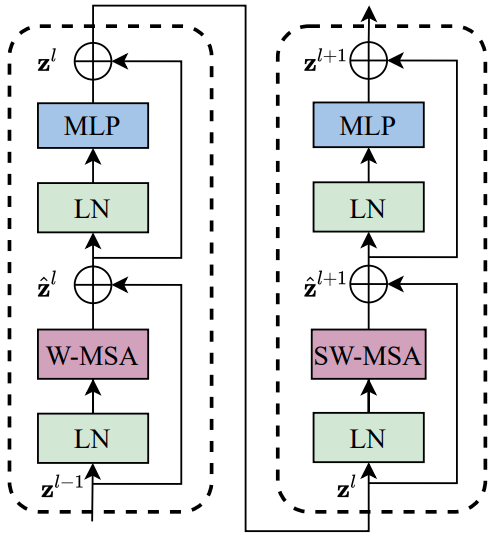

#### Multilayer Perceptron
A Multilayer Perceptron (MLP) consists basically two dense layers and a GELU activation layer. It is used in the classical Transformer architecture and it is also used in the Swin Transformer blocks. We can simply implement it as custom layer as follows:

In [156]:
@keras.saving.register_keras_serializable()
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [ ]:
mlp = MLP(768 * 2, 768)
y = mlp(tf.zeros((1, 197, 768)))
y.shape

#### Window multi-head self-attention
The following implementaiton support boths of shifted and non-shifted window attention.

In [157]:
@keras.saving.register_keras_serializable()
class WindowAttention(Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        initializer = TruncatedNormal(mean=0., stddev=.02)
        # position table shape is: (2*Wh-1 * 2*Ww-1, nH)
        table_shape = ((2*self.window_size[0]-1) * (2*self.window_size[1]-1), num_heads)
        self.relative_position_bias_table = tf.Variable(initializer(shape=table_shape))

        # get pair-wise relative position index for each token inside the window
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w))  # 2, Wh, Ww
        coords_flatten = tf.reshape(coords, [2, -1])  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = tf.transpose(relative_coords, perm=[1,2,0]) # Wh*Ww, Wh*Ww, 2
        relative_coords = relative_coords + [self.window_size[0] - 1, self.window_size[1] - 1]  # shift to start from 0
        relative_coords = relative_coords * [2*self.window_size[1] - 1, 1]
        self.relative_position_index = tf.math.reduce_sum(relative_coords,-1)  # Wh*Ww, Wh*Ww

        self.qkv = Dense(dim * 3, use_bias=qkv_bias, kernel_initializer=initializer)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, kernel_initializer=initializer)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(axis=-1)

    def call(self, x, mask=None):
        _, L, N, C = x.shape
        qkv = tf.transpose(tf.reshape(self.qkv(x), [-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4]) # [3, B_, num_head, Ww*Wh, C//num_head]
        q, k, v = tf.unstack(qkv)  # make torchscript happy (cannot use tensor as tuple)
        q = q * self.scale
        attn = tf.einsum('...ij,...kj->...ik', q, k)
        relative_position_bias = tf.reshape(tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1])),
            [self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2, 0, 1])  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias

        if mask is not None:
            nW = mask.shape[0] # every window has different mask [nW, N, N]
            attn = tf.reshape(attn, [-1 // nW, nW, self.num_heads, N, N]) + mask[:, None, :, :] # add mask: make each component -inf or just leave it
            attn = tf.reshape(attn, [-1, self.num_heads, N, N])
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = tf.reshape(tf.transpose(attn @ v, perm=[0, 2, 1, 3]), [-1, L, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [29]:
attn = WindowAttention(96, window_size=(4, 4), num_heads=8, qkv_bias=True, qk_scale=None, attn_drop=0.0, proj_drop=0.0)
y = attn(tf.zeros((1, 196, 16, 96)))
y.shape

TensorShape([1, 196, 16, 96])

#### Helper functions
Before defining the Swin Transformer block, we need couple helper functions to create create windows and merge them.


First, `window_partition` which as the name suggest create windows from the input tensor

In [158]:
@keras.saving.register_keras_serializable()
def window_partition(x, window_size):
    _, H, W, C = x.shape
    num_patch_y = H // window_size
    num_patch_x = W // window_size
    x = tf.reshape(x, [-1, num_patch_y, window_size, num_patch_x, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, [-1, num_patch_x * num_patch_y, window_size, window_size, C])
    return windows

In [ ]:
windows = window_partition(batch, 4)
print(f'Input shape (B,   H,  W,  C) = {batch.shape}')
print(f'Ouput shape (num_windows*B, window_size, window_size, C) = {windows.shape}')

Second, `window_reverse` which as the name suggest reverse the created windows

In [159]:
@keras.saving.register_keras_serializable()
def window_reverse(windows, window_size, H, W):
    C = tf.shape(windows)[-1]  # Get the channel dimension
    B = tf.shape(windows)[0]  # Batch size at runtime
    x = tf.reshape(windows, [B, H // window_size, W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])  # Reorder dimensions
    x = tf.reshape(x, [B, H, W, C])  # Reshape to the original dimensions
    return x


In [ ]:
y = window_reverse(windows, 4, 128, 128)
print(f'Input shape (B, num_windows*B, window_size, window_size, C) = {windows.shape}')

print(f'Ouput shape (B,   H,  W,  C) = {y.shape}')

In [160]:
@keras.saving.register_keras_serializable()
class DropPath(Layer):
    def __init__(self, prob):
        super().__init__()
        self.drop_prob = prob

    def call(self, x, training=None):
        if self.drop_prob == 0. or not training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = tf.random.uniform(shape=shape)
        random_tensor = tf.where(random_tensor < keep_prob, 1, 0)
        output = x / keep_prob * random_tensor
        return output

In [ ]:
drop = DropPath(0.2)
y = drop(tf.zeros((1, 197, 768)))
y.shape

### SwinTransformerBlock
With the shifted window partitioning approach, consecutive Swin Transformer blocks are computed as

In [161]:
@keras.saving.register_keras_serializable()
class SwinTransformerBlock(Layer):

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else tf.identity
        self.norm2 = LayerNormalization(epsilon=1e-5)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(mlp_hidden_dim, dim, dropout_rate=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            img_mask = tf.constant(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = tf.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = mask_windows[:, None, :] - mask_windows[:, :, None]
            self.attn_mask = tf.where(attn_mask==0, -100., 0.)
        else:
            self.attn_mask = None

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, [-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = tf.reshape(x_windows, [-1, x_windows.shape[1], self.window_size * self.window_size, C])  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = tf.reshape(attn_windows, [-1, x_windows.shape[1], self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=(1, 2))
        else:
            x = shifted_x
        x = tf.reshape(x, [-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


In [ ]:
block = SwinTransformerBlock(12, (64, 64), 8, window_size=2) # 32 is square root of num_patches which is 1024
y = block(embeddings[:8])
y.shape

In [ ]:
p = PatchMerging((64, 64), channels=12)(y)
p.shape

### Putting it together
After defining all the major components of the Swin-T architecture, we can put them together to build the model. This is fairly straightforward now as we just need to plug a window partition to an blocks of Swin Transformers separated by a merging layer. For classification, we add a pooling then a dense layer to the form the head of the model.


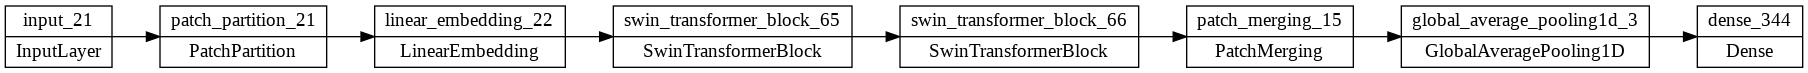


In [185]:
def encoder(x, dim, input_resolution, num_heads, window_size):
    x = SwinTransformerBlock(
        dim=dim, 
        input_resolution=input_resolution,
        num_heads=num_heads,
        window_size=window_size,
        shift_size=0
    )(x)

    x = SwinTransformerBlock(
        dim=dim, 
        input_resolution=input_resolution,
        num_heads=num_heads,
        window_size=window_size,
        shift_size=2
    )(x)
    B, L, C = x.shape
    H = W = int(np.sqrt(L))
    skip = Reshape((H, W, C))(x)
   
    return x, skip

In [184]:
def attention_block(g, x, num_filters):
    shape_g = K.int_shape(g)
    shape_x = K.int_shape(x)

    Wg = Conv2D(num_filters, (1, 1), strides=1, padding='same')(g)
    Wg = BatchNormalization()(Wg)
    #print(f"Wg: {Wg.shape}")
    Wx = Conv2D(num_filters, (1, 1), strides=2, padding='same')(x)
    Wx = BatchNormalization()(Wx)
    #print(f"Wx: {Wx.shape}")
    
    concat_xg = Add()([Wg, Wx])
    #print(f"Concatenation in Attention: {concat_xg.shape}")
    #relu_act_xg = Activation('relu')(Wg + Wx)
    relu_act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(relu_act_xg)
    #print(f"PSI: {psi.shape}")
    sig_act_xg = Activation('sigmoid')(psi)
    shape_sig = K.int_shape(sig_act_xg)

    #upsample = UpSampling2D(size = (shape_x[1] // shape_sig[1], shape_x[2] // shape_sig[2]))(sig_act_xg)

    upsample = Conv2DTranspose(num_filters, kernel_size= (2 , 2), strides=2, padding='same')(sig_act_xg)
    #3print(f"upsample: {upsample.shape} and x {x.shape}")
    out = Multiply()([upsample, x])
    #print(f"out: {out.shape}")
    x = Conv2D(num_filters, (1, 1), strides=2, padding='same')(out)
    x = Conv2D(num_filters, (1, 1), strides=1, padding='same')(x)
    #print(f"out: {x.shape}")

    return x


In [186]:
def decoder(x, num_filter, skip, num_heads, window_size):
    B, L, C = x.shape
    H = W = int(np.sqrt(L))
    x = Reshape((H, W, C))(x)
    #print(f"Before Attention: {x.shape}")
    x = attention_block(x, skip, num_filter)
    #print(f"Output of Attention: {x.shape}")
    
    x = Conv2DTranspose(num_filter, kernel_size=2, strides=2)(x)
    #print(f"x: {x.shape} and skip: {skip.shape}")
    x = Concatenate()([x, skip])
    x = Conv2D(num_filter, kernel_size=2, padding='same', kernel_initializer="he_uniform", activation='relu')(x)
    x = Conv2D(num_filter, kernel_size=2, padding='same', kernel_initializer="he_uniform", activation='relu')(x)
    #print(f"Concatenate: {x.shape}")
    B, H, W, C = x.shape
    #print(f"Height and Width: {H} x {W}")
    x = Reshape((H * W, C))(x)
    #print(f"Reahape: {x.shape}")
    x = SwinTransformerBlock(
        dim=C,
        input_resolution=(H, W),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=0
    )(x)

    return x

In [257]:
def create_SwinTransformer(
    num_classes, 
    input_shape=(128, 128, 3), 
    window_size= 4,#[8, 4, 2, 2], 
    #embed_dim=192,
    num_heads= 8, #[4, 8, 16, 32], 
    num_layers=4,
    patch_size = 2
):
    
    num_patch_x = input_shape[0] // patch_size
    num_patch_y = input_shape[1] // patch_size
    inputs = Input(shape=input_shape)
    print(f"Input: {inputs.shape}")
    print(f"X_input_patches: {num_patch_x} \nY_input_patches: {num_patch_y}")

    # Patch extractor
    patches = PatchPartition(patch_size)(inputs)
    print(f"PatchPartition: {patches.shape}")
    x = LinearEmbedding(num_patch_x * num_patch_y, 32)(patches)
    print(f"Linear Embedding after patching: {x.shape} \n")
    
    # Swin Transformer Encoder
    print("Encoder Path...!")
    # Stage 1 (64 x 64 resolution)
    x, skip1 = encoder(x, dim=32, input_resolution=(64, 64), num_heads=8, window_size=8)
    print(f"Stage 1 \nX: {x.shape} \nSkip: {skip1.shape} \n")

    # Stage 2 (32 x  32 resolution)
    x = PatchMerging(input_resolution=(64, 64), channels=32)(x)
    print(f"Stage 2 \nPatchMerging: {x.shape}")
    x, skip2 = encoder(x, dim=64, input_resolution=(32, 32), num_heads=16, window_size=8)
    print(f"X: {x.shape} \nSkip: {skip2.shape} \n")

    # Stage 3 (16 x  16 resolution)
    x = PatchMerging(input_resolution=(32, 32), channels=64)(x)
    print(f"Stage 3 \nPatchMerging: {x.shape}")
    x, skip3 = encoder(x, dim=128, input_resolution=(16, 16), num_heads=32, window_size=4)
    print(f"X: {x.shape} \nSkip: {skip3.shape} \n")

     # Stage 4 (8 x  8 resolution)
    x = PatchMerging(input_resolution=(16, 16), channels=128)(x)
    print(f"Stage 4 \nPatchMerging: {x.shape}")
    x, skip4 = encoder(x, dim=256, input_resolution=(8, 8), num_heads=64, window_size=4)
    print(f"X: {x.shape} \nSkip: {skip4.shape} \n")
    
     # Bottleneck (4 x 4 resolution)
    x = PatchMerging(input_resolution=(8, 8), channels=256)(x)
    print(f"Bottleneck \nPatchMerging: {x.shape}")
    x, skip_bottleneck = encoder(x, dim=512, input_resolution=(4, 4), num_heads=128, window_size=4)
    print(f"X: {x.shape} \nSkip: {skip_bottleneck.shape} \n")
  

    # Swin Transformer Decoder
    print("Decoder Path...!")
    x = decoder(x, num_filter=256, skip=skip4, num_heads=64, window_size=4)
    print(f"Upconv 1 : {x.shape}")

    x = decoder(x, num_filter=128, skip=skip3, num_heads=32, window_size=4)
    print(f"Upconv 2 : {x.shape}")

    x = decoder(x, num_filter=64, skip=skip2, num_heads=16, window_size=8)
    print(f"Upconv 3 : {x.shape}")

    x = decoder(x, num_filter=32, skip=skip1, num_heads=8, window_size=8)
    print(f"Upconv 4 : {x.shape} \n")
  

    # Final 
    B, L, C = x.shape
    H = W = int(np.sqrt(L))
    x = Reshape((H, W, C))(x)
    print(f"Reshape for final layer : {x.shape}")
    x = Conv2DTranspose(16, kernel_size=2, strides=2)(x)
    print(f"Final Upsampling {x.shape} \n")

    # Output layer
    output = Conv2D(num_classes, kernel_size= 1, activation='sigmoid')(x)
    print(f"Output: {output.shape}")
    model = Model(inputs, output)

    return model


In [258]:
#model = create_SwinTransformer(1)(X_train)
model = create_SwinTransformer(1)
model.summary()

Input: (None, 128, 128, 3)
X_input_patches: 64 
Y_input_patches: 64
PatchPartition: (None, None, 12)
Linear Embedding after patching: (None, 4096, 32) 

Encoder Path...!
Stage 1 
X: (None, 4096, 32) 
Skip: (None, 64, 64, 32) 

Stage 2 
PatchMerging: (None, 1024, 64)
X: (None, 1024, 64) 
Skip: (None, 32, 32, 64) 

Stage 3 
PatchMerging: (None, 256, 128)
X: (None, 256, 128) 
Skip: (None, 16, 16, 128) 

Stage 4 
PatchMerging: (None, 64, 256)
X: (None, 64, 256) 
Skip: (None, 8, 8, 256) 

Bottleneck 
PatchMerging: (None, 16, 512)
X: (None, 16, 512) 
Skip: (None, 4, 4, 512) 

Decoder Path...!
Upconv 1 : (None, 64, 256)
Upconv 2 : (None, 256, 128)
Upconv 3 : (None, 1024, 64)
Upconv 4 : (None, 4096, 32) 

Reshape for final layer : (None, 64, 64, 32)
Final Upsampling (None, 128, 128, 16) 

Output: (None, 128, 128, 1)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_partition_35        │ (None, None, 12)       │              0 │ input_layer_35[0][0]   │
│ (PatchPartition)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ linear_embedding_35       │ (None, 4096, 32)       │        131,488 │ patch_partition_35[0]… │
│ (LinearEmbedding)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 4096, 32)       │         12,704 │ linear_embedding_35[0… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 4096, 32)       │         12,704 │ swin_transformer_bloc… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_merging_134         │ (None, 1024, 64)       │          8,192 │ swin_transformer_bloc… │
│ (PatchMerging)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 1024, 64)       │         49,984 │ patch_merging_134[0][… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 1024, 64)       │         49,984 │ swin_transformer_bloc… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_merging_135         │ (None, 256, 128)       │         32,768 │ swin_transformer_bloc… │
│ (PatchMerging)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 256, 128)       │        198,272 │ patch_merging_135[0][… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 256, 128)       │        198,272 │ swin_transformer_bloc… │
│ (SwinTransformerBlock)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_merging_136         │ (None, 64, 256)        │        131,072 │ swin_transformer_bloc… │
│ (PatchMerging)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ swin_transformer_block_3… │ (None, 64, 256)        │        789,760 │ patch_merging_136[0][… │
│ (SwinTransformerBlock)    │                        │                │                        │
├──────────────────────

 Total params: 12,124,741 (46.25 MB)

 Trainable params: 12,122,821 (46.24 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [236]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast y_pred to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [235]:
class_specific_metrics = [
    tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]),  # IoU for each class (0 and 1)
    dice_coefficient  # Custom Dice Coefficient
]
#tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
#tf.keras.metrics.MeanIoU(num_classes=2, target_class_ids=[1])

In [237]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [259]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # clipvalue=0.5
    loss= tf.keras.losses.BinaryCrossentropy(), #bce_dice_loss, #"binary_crossentropy",
    metrics=["accuracy"] #+ class_specific_metrics  # Include both IoU and Dice metrics
)

In [260]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

In [264]:
lr_scheduler_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1
)

lr_scheduler_accuracy = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.3, patience=4, min_lr=1e-7, verbose=1
)

In [241]:
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

print(X_train_norm.shape, X_test_norm.shape)
print(y_train.shape, y_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)
(2272, 128, 128, 1) (569, 128, 128, 1)


In [262]:
checkpoint_loss = ModelCheckpoint(
    filepath='swin_model_val_loss.keras',
    save_best_only=True,
    monitor='val_loss',  # You can adjust this to the desired metric
    mode='min',          # Use 'min' for loss and 'max' for accuracy
    verbose=1
)

In [263]:
checkpoint_accuracy = ModelCheckpoint(
    filepath='swin_model_val_accuracy.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [244]:
file_path = "/kaggle/working/swin_model.keras"  # Change to your actual file path
if os.path.exists(file_path):
    os.remove(file_path)
    print("File deleted successfully")
else:
    print("File not found")

File not found


In [265]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size = 20,
    callbacks = [lr_scheduler_loss,lr_scheduler_accuracy, checkpoint_loss,checkpoint_accuracy, c1]
)

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.6054 - loss: 2.2213
Epoch 1: val_loss improved from inf to 0.63345, saving model to swin_model_val_loss.keras

Epoch 1: val_accuracy improved from -inf to 0.68102, saving model to swin_model_val_accuracy.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 148s 649ms/step - accuracy: 0.6058 - loss: 2.2118 - val_accuracy: 0.6810 - val_loss: 0.6335 - learning_rate: 0.0010
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6919 - loss: 0.6085
Epoch 2: val_loss improved from 0.63345 to 0.55703, saving model to swin_model_val_loss.keras

Epoch 2: val_accuracy improved from 0.68102 to 0.72217, saving model to swin_model_val_accuracy.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 243ms/step - accuracy: 0.6920 - loss: 0.6083 - val_accuracy: 0.7222 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7235 - loss: 0.5530
Epoch 3: val_loss improved from 0.55703 to 0.53472, savin

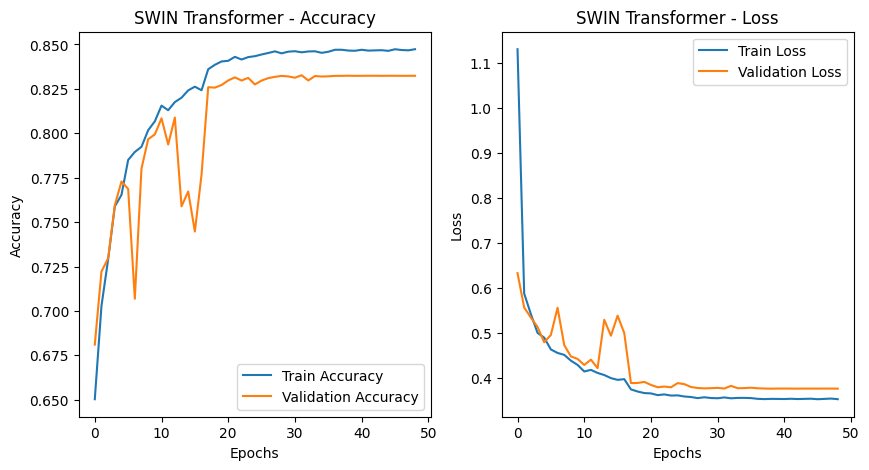

In [266]:
plot_training_history(history, "SWIN Transformer")

In [267]:
import pickle
with open('/kaggle/working/swin_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [274]:
trained_history = trained_history('/kaggle/working/swin_history.pkl', model, ['Swin (Training)', 'Swin (Validation)'], X_train, y_train, X_test, y_test)
print(trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step
           Algorithm  Accuracy      Loss      mIOU
0    Swin (Training)  0.847339  0.353405  0.628148
1  Swin (Validation)  0.832374  0.376850  0.594395


In [275]:
swin_mask = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step


In [224]:
from tensorflow.keras.models import load_model
#trained_model = load_model("/kaggle/working/swin_model.keras")

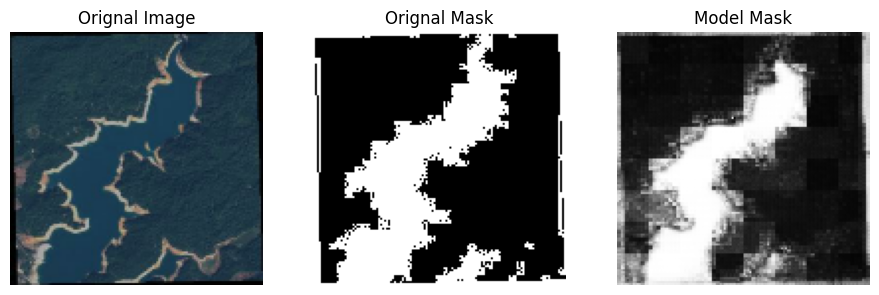

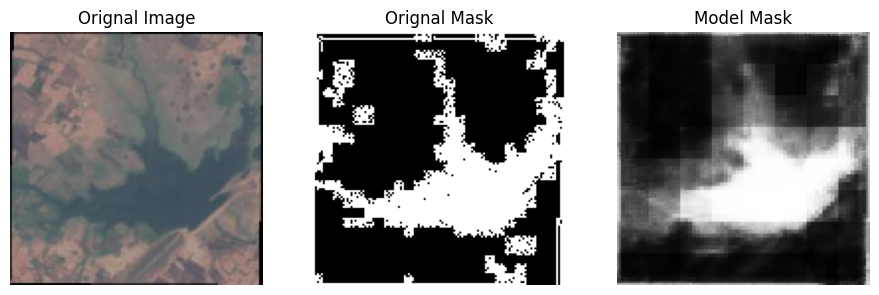

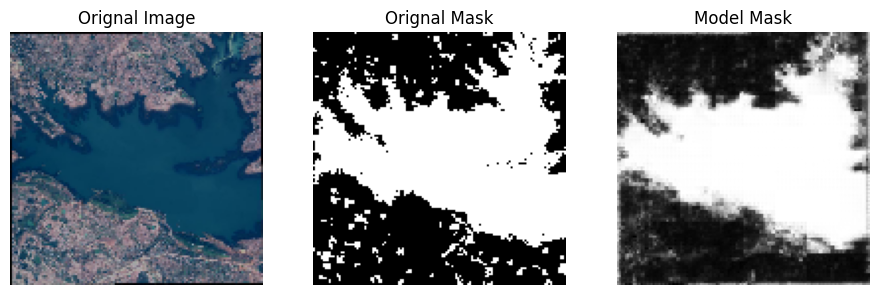

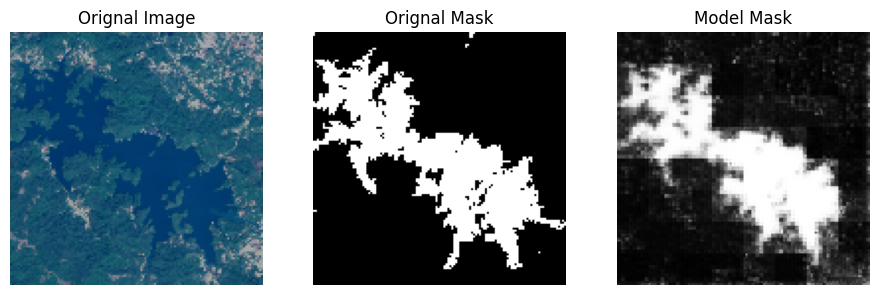

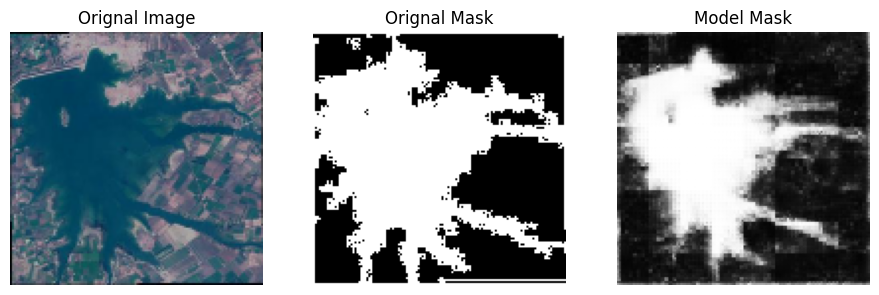

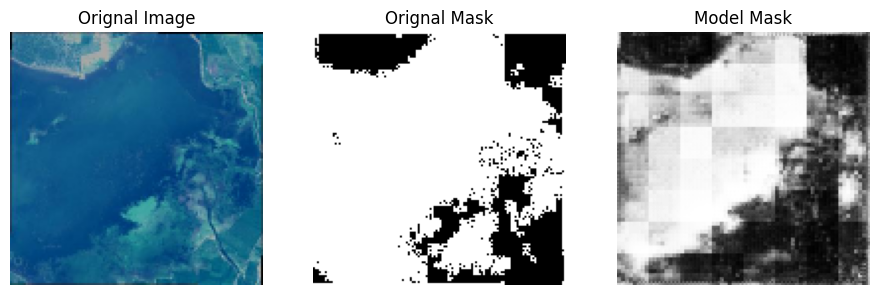

In [276]:
plot_images(X_test, y_test, swin_mask, selected_indices = [1, 31, 22, 25, 46, 95])